In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline

# Задача 1

Сгенерировать M = 100 выборок размера N = 1000 из номрального распределения с параметром $\theta$, посчитать оценки: 
$2\overline{X}, (n+1)X_{(1)}, X_{(1)} + X_{(n)}, \frac{n+1}{n}X_{(n)}$. Построить график усредненной по m квадратичной функции потерь $(\hat{\theta} - \theta)^2$ в зависимости от n для трех различных значений $\theta$.

In [2]:
M = 100
N = 1000

In [3]:
def make_samples(theta):
    return sps.uniform.rvs(size = (M, N), loc = 0, scale = theta)

def make_estims(samples):
    estims = np.zeros((4, M, N))
    estims[0] = 2 * np.cumsum(samples, axis = 1) / np.arange(1, N + 1)
    estims[1] = np.minimum.accumulate(samples, axis = 1) * np.arange(2, N + 2)
    estims[2] = np.minimum.accumulate(samples, axis = 1) + np.maximum.accumulate(samples, axis=1)
    estims[3] = np.maximum.accumulate(samples, axis = 1) * np.arange(2, N + 2) / np.arange(1, N + 1)
    return estims

def count_loss_avg(estims, theta):
    loss_avgs = np.zeros((4, N))
    for i in range(4):
        loss_avgs[i] = np.mean((estims[i] - theta) ** 2, axis = 0)
    return loss_avgs

In [4]:
def draw_plot(loss_avgs):
    plt.figure(figsize = (12, 6))
    names = [r'$2\overline{X}$', r'$(n + 1)X_{(1)}$', r'$X_{(1)} + X_{(n)}$', r'$\frac{n + 1}{n}X_{(n)}$']
    for i, name in zip(range(4), names):
        plt.plot(range(0, N), loss_avgs[i], label=name)
        
    plt.title(r"""Зависимость усредненной функции потерь от размера выборки $(\theta$ = {})""".format(theta))
    plt.xlabel("n")
    plt.ylabel(r"$(\hat{\theta} - \theta)^2$")
    plt.legend()

In [5]:
def solution(theta):
    samples = make_samples(theta)
    estims = make_estims(samples)
    loss_avgs = count_loss_avg(estims, theta)
    draw_plot(loss_avgs)

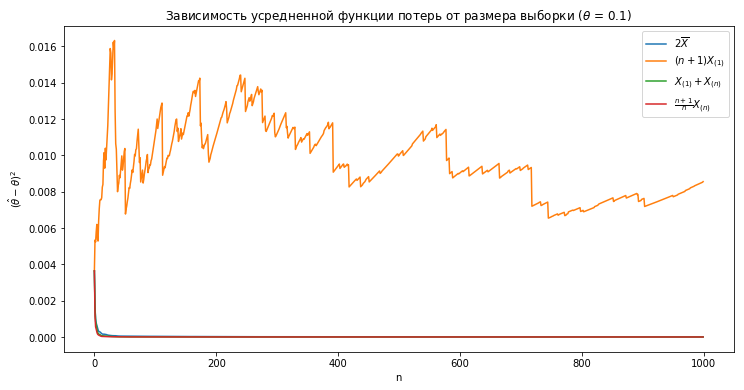

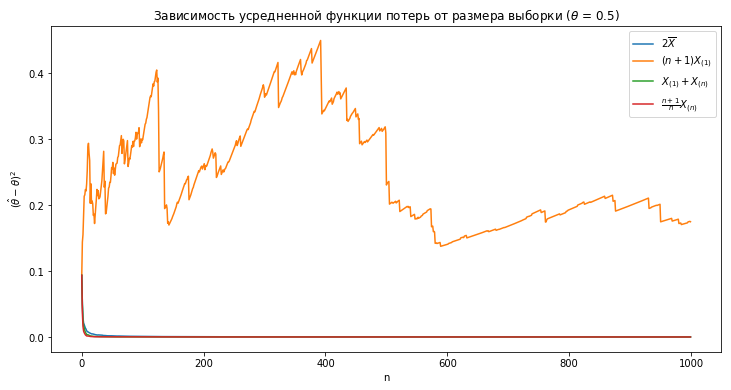

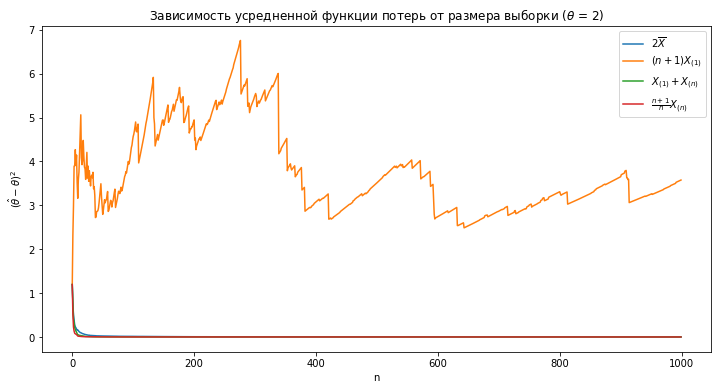

In [6]:
for theta in [0.1, 0.5, 2]:
    solution(theta)

**Вывод**

Матожидание функций потерь всех оценок, кроме $(n+1)X_{(1)}$, стремится к нулю. У $(n+1)X_{(1)}$ оно равно $\frac{n\theta^2}{n+2}$ и стремится к $\theta^2$. На графиках это подтверждается.

# Задача 2

В этой задаче один из параметров распределений $\theta$ берется из $R[0, 1]$. Размер первоначальной выборки N = 1000.

In [59]:
N = 1000
K = 500

In [60]:
def s2(data):
    return (data ** 2).mean() - data.mean() ** 2

In [61]:
def get_variance_estims(sample_estims, create_bootstrap_samples, estimate_bootstrap):
    variance_estims = np.zeros(N)
    for n in range(N):
        bootstrap_samples = create_bootstrap_samples(n, sample_estims)
        bootstrap_estims = np.zeros(K)
        for i in range(K):
            bootstrap_estims[i] = estimate_bootstrap(n, bootstrap_samples[i])
        variance_estims[n] = s2(bootstrap_estims)
    return variance_estims

In [70]:
def draw_plot(efficient_variance_estims, unbiased_variance_estims, ixs, names, start = 0):
    plt.figure(figsize = (14, 8))
    plt.title(r'Зависимость оценки дисперсии распределения {} от оценки параметра $\theta$'.format(names[0]))
    plt.xlabel('n')
    plt.ylabel(r'$s^2$')
    plt.plot(range(start, N), efficient_variance_estims, label = names[1])
    plt.plot(range(start, N), unbiased_variance_estims, label = names[2])
    plt.plot(range(start, N), ixs, label = names[3])
    plt.legend()

### Биномиальное распределение

Cгенерируем выборку из $Bern(n, \theta)$, m = 50$.

In [63]:
m = 50
theta = sps.uniform(loc = 0, scale = 1).rvs(size = 1)[0]
sample = sps.binom(m, theta).rvs(size = N)

Для каждого $n \leqslant N$ посчитаем бутстрепную оценку дисперсии эффективной оценки биномиального распределения $\frac{\overline{X}}{m}$. 
Сделаем то же самое для несмещенной оценки  $\frac{X_{1}}{m}$. 
Посчитаем $\frac{1}{I_X(\theta)} = \frac{\theta(1 - \theta)}{nm}$ для каждого n.

In [64]:
def create_binom_bootstrap_samples(n, estims):
    return sps.binom(m, estims[n]).rvs(size = (K, n + 1))

In [65]:
efficient_estims = np.cumsum(sample) / np.arange(1, N + 1) / m
efficient_variance_estims = get_variance_estims(
    efficient_estims, 
    create_binom_bootstrap_samples, 
    lambda n, sample: np.mean(sample) / m
)

In [66]:
unbiased_estims = np.minimum.accumulate(sample) / m
unbiased_variance_estims = get_variance_estims(
    unbiased_estims, 
    create_binom_bootstrap_samples, 
    lambda n, sample: np.min(sample) / m
)

In [67]:
ixs = [theta * (1 - theta) / n / m  for n in range(1, N + 1)]

Построим график с результатами

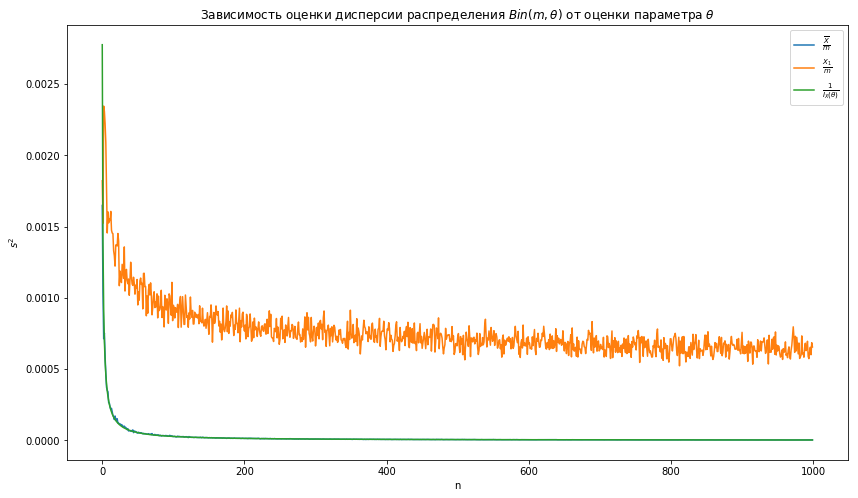

In [68]:
names = [r'$Bin(m, \theta)$', r'$\frac{\overline{X}}{m}$', r'$\frac{X_1}{m}$', r'$\frac{1}{I_X(\theta)}$']
draw_plot(efficient_variance_estims, unbiased_variance_estims, ixs, names)

На графике видим, что дисперсия эффективной оценки совпадает с обратной к информации Фишера величине, а дисперсия несмещещенной оценки больше их обеих. Это подтверждает неравенство Рао-Крамера: $\frac{1}{I_X(p)} \leqslant var_{p}\hat{p}$, а равенство наступает iff $\hat{p}$ - эффективная оценка параметра $p$.

### Экспоненциальное распределение

Сгенерируем выборку из $exp(\theta)$

In [71]:
theta = sps.uniform(loc = 0, scale = 1).rvs(size = 1)[0]
sample = sps.expon(scale = 1 / theta).rvs(size = N)

Найдем бутстрепную оценку дисперсии эффективной оценки $\overline{X}$ и несмещенной оценки $\frac{n \overline{X}}{n - 1}$ параметра $\frac{1}{\theta}$ в зависимости от размера выборки. Посчитаем $\frac{(\tau'(\theta))^2}{I_X(a)} = \frac{1}{n \theta^2}$ для каждого n.

In [74]:
def create_expon_bootstrap_samples(n, estims):
    return sps.expon(scale = estims[n]).rvs(size = (K, n + 1))

In [75]:
efficient_estims = np.cumsum(sample) / np.arange(1, N + 1)
efficient_variance_estims = get_variance_estims(
    efficient_estims, 
    create_expon_bootstrap_samples,
    lambda n, sample: np.mean(sample)
)

In [76]:
unbiased_estims = np.cumsum(sample) * np.arange(1, N + 1) / np.append([1], np.arange(1, N))
unbiased_variance_estims = get_variance_estims(
    unbiased_estims,
    create_expon_bootstrap_samples,
    lambda n, sample: np.mean(sample) * n / max(1, n - 1)
)

In [ ]:
def get_variance_estims(sample_estims, estimate_bootstrap):
    variance_estims = np.zeros(N)
    for n in range(N):
        bootstrap_samples = sps.expon(scale = estims[n]).rvs(size = (K, n + 1))
        bootstrap_estims = np.zeros(K)
        for i in range(K):
            bootstrap_estims[i] = estimate_bootstrap(n, bootstrap_samples[i])
        variance_estims[n] = s2(bootstrap_estims)
    return variance_estims

In [77]:
ixs = [1 / (n * theta ** 2) for n in range(1, N + 1)]

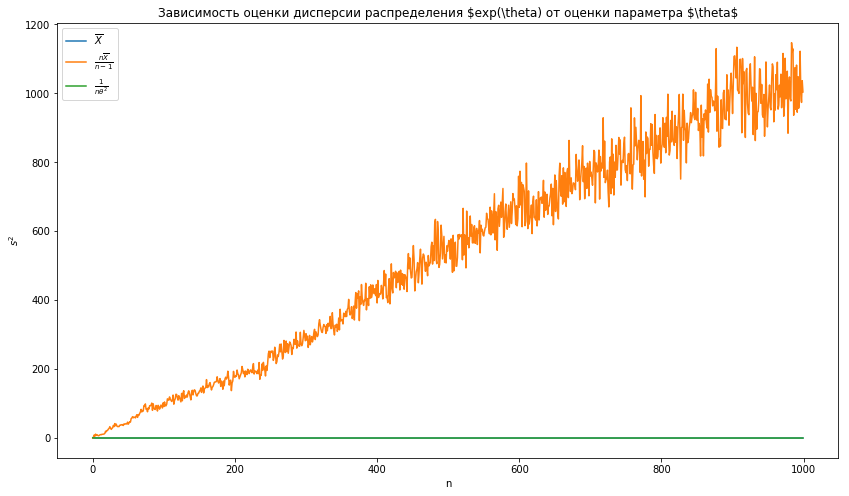

In [78]:
names = [r'$exp(\theta)', r'$\overline{X}$', r'$\frac{n \overline{X}}{n - 1}$', r'$\frac{1}{n \theta^2}$']
draw_plot(efficient_variance_estims, unbiased_variance_estims, ixs, names)